In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load and preprocess the dataset
data = pd.read_excel('Train_Data.xlsx')  # Replace with your file name
data = data.dropna()
data = data.drop(columns=['Date'])  # Drop Date column if not needed

# Feature aggregation function
def aggregate_features(data, num_stations):
    """
    Aggregate features for the given number of stations.
    Args:
        data (DataFrame): Input dataset.
        num_stations (int): Number of stations provided for prediction.
    Returns:
        X (ndarray): Aggregated features for the model.
        y (ndarray): Target delays for the next station.
    """
    aggregated_features = []

    # Aggregate features (e.g., average of temperature, distance, wind speed, etc.)
    avg_temperature = np.mean([data[f'Temperature_S{i}'] for i in range(1, num_stations + 1)], axis=0)
    avg_wind_speed = np.mean([data[f'Wind_Speed_S{i}'] for i in range(1, num_stations + 1)], axis=0)
    avg_distance = np.mean([data[f'Distance_travelled_S{i}'] for i in range(1, num_stations + 1)], axis=0)
    avg_weather_code = np.mean([data[f'weather_code_S{i}'] for i in range(1, num_stations + 1)], axis=0)
    
    # Add delay of previous stations (as a feature for predicting the next station's delay)
    avg_previous_delay = np.mean([data[f'S{i}'] for i in range(1, num_stations + 1)], axis=0)
    
    # Combine all aggregated features into a single feature vector
    aggregated_features.append(avg_temperature)
    aggregated_features.append(avg_wind_speed)
    aggregated_features.append(avg_distance)
    aggregated_features.append(avg_weather_code)
    aggregated_features.append(avg_previous_delay)
    
    X = np.column_stack(aggregated_features)  # Stack features as columns
    y = data[f'S{num_stations + 1}'].values  # Delay at the next station
    return X, y

# Function to train and evaluate the model
def train_and_evaluate(data, num_stations):
    # Aggregate features and target
    X, y = aggregate_features(data, num_stations)
    
    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Train-Test Split
    train_size = int(0.8 * X_scaled.shape[0])
    X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
    y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

    # Build the Dense model
    model = Sequential([
        Dense(200, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.3),
        Dense(100, activation='relu'),
        Dropout(0.3),
        Dense(1)  # Predicting delay for the next station
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

    # Predictions
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Evaluation
    y_test_actual = scaler_y.inverse_transform(y_test)
    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_actual, y_pred)

    print(f"Number of Stations: {num_stations}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-Squared (R²): {r2}")

    # Plot predictions vs actual using scatter plot
    # Scatter plot of Actual vs Predicted Delays
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_actual, y_pred, color='blue', alpha=0.6)
    plt.xlabel('Actual Delay')
    plt.ylabel('Predicted Delay')
    plt.title(f'Actual vs Predicted Delays at Next Station (Stations: {num_stations})')
    plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--')  # Diagonal line for perfect prediction
    plt.show()
    

    return model, scaler_X, scaler_y

# Function for prediction based on user input
def predict_delay(model, scaler_X, scaler_y, data, num_stations):
    # Aggregate features for the given number of stations
    X_input, _ = aggregate_features(data, num_stations)
    X_input_scaled = scaler_X.transform(X_input)

    # Predict the delay for the next station
    delay_scaled = model.predict(X_input_scaled)
    delay = scaler_y.inverse_transform(delay_scaled)

    print(f"Predicted Delay at Station {num_stations + 1}: {delay[0][0]}")

# Example Usage
# Train the model with data from 2nd to 10th station
model, scaler_X, scaler_y = train_and_evaluate(data, num_stations=9)

# Predict delay for a given number of stations (e.g., 5 stations)
predict_delay(model, scaler_X, scaler_y, data, num_stations=5)

# Predict delay for a different number of stations (e.g., 6 stations)
predict_delay(model, scaler_X, scaler_y, data, num_stations=6)


KeyboardInterrupt: 


Training and Testing for 2 Stations
Epoch 1/100


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0264 - val_loss: 0.0060
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - val_loss: 0.0026
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - val_lo

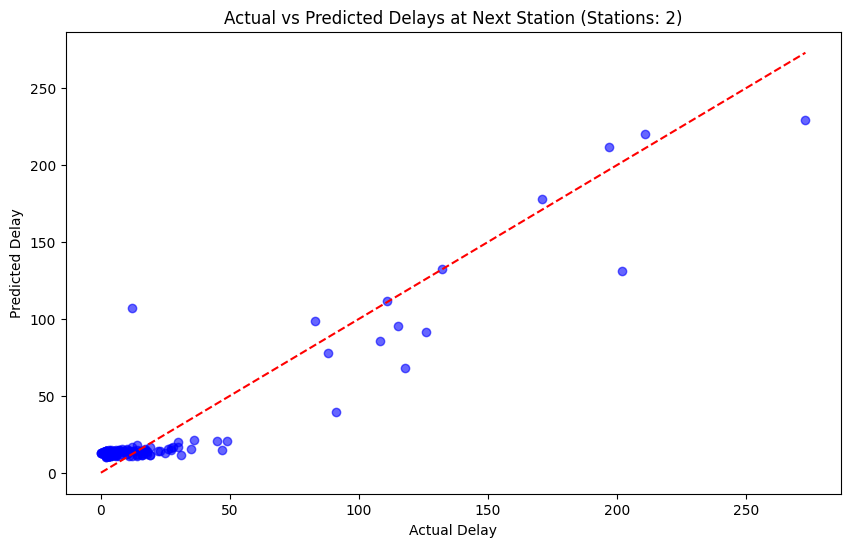


Training and Testing for 3 Stations
Epoch 1/100


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0339 - val_loss: 0.0114
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - val_loss: 0.0056
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - val_loss: 0.0030
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_lo

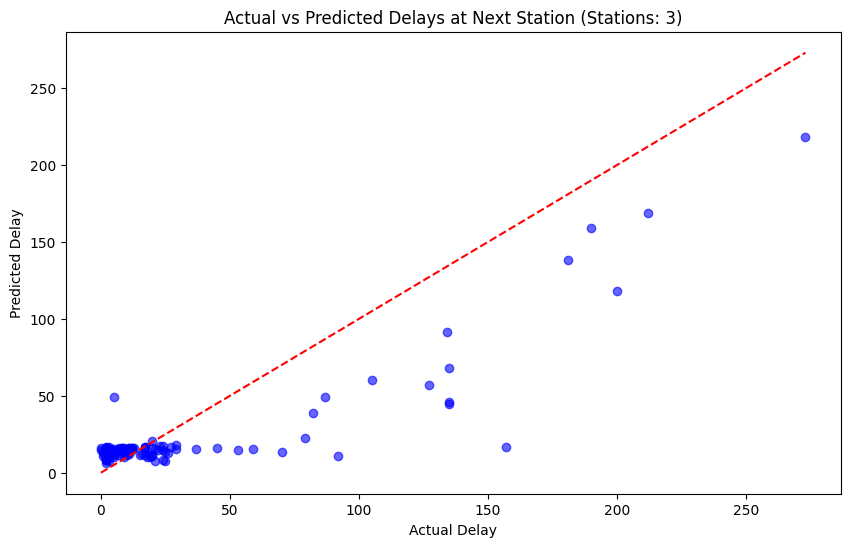


Training and Testing for 4 Stations
Epoch 1/100


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0278 - val_loss: 0.0056
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0036
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - val_loss: 0.0017
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_lo

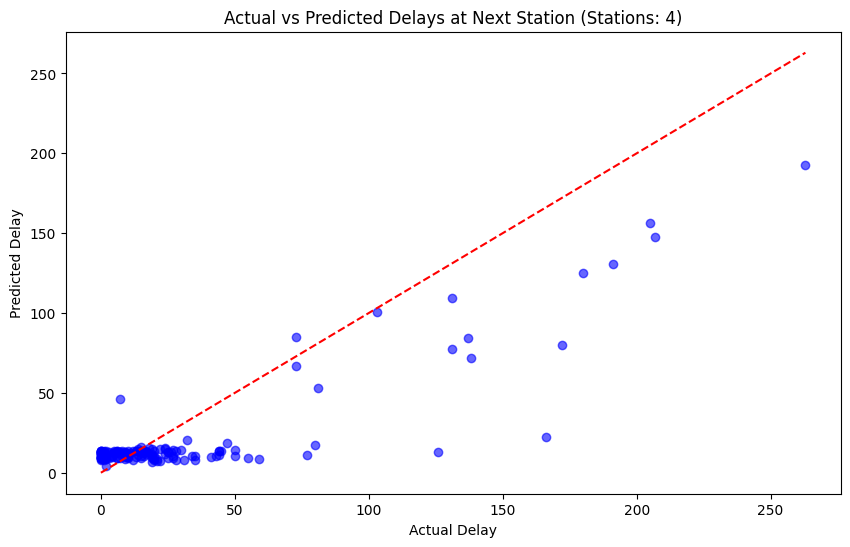


Training and Testing for 5 Stations
Epoch 1/100


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0194 - val_loss: 0.0042
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0025
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - val_loss: 9.7413e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 7.0878e-04
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 9.7519e-04
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 9.2223e-04
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 9.2478e-04
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 8.8129e-04
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 8.9143e-04
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

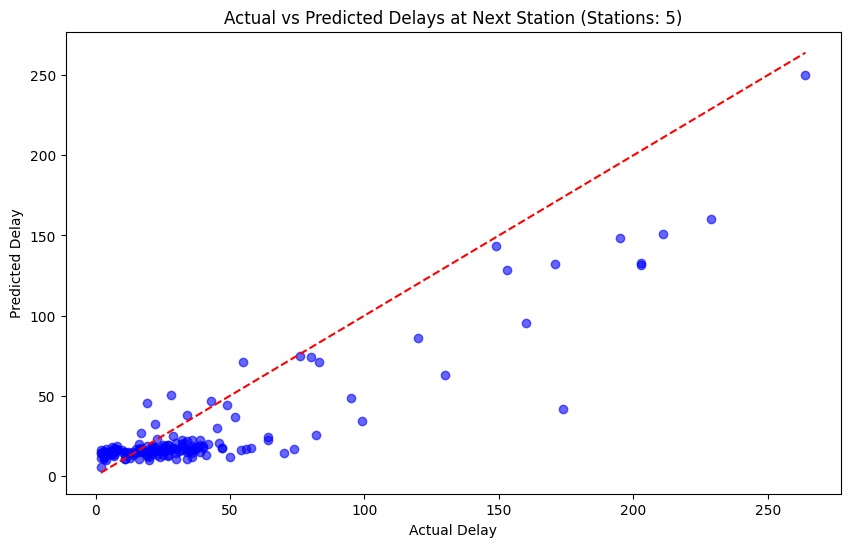


Training and Testing for 6 Stations
Epoch 1/100


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0260 - val_loss: 0.0021
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 8.0744e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 6.2537e-04
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 5.2346e-04
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 4.8464e-04
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 4.8037e-04
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 4.7678e-04
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 9.8095e-04
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 5.6004e-04
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 4.7414e-04
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━

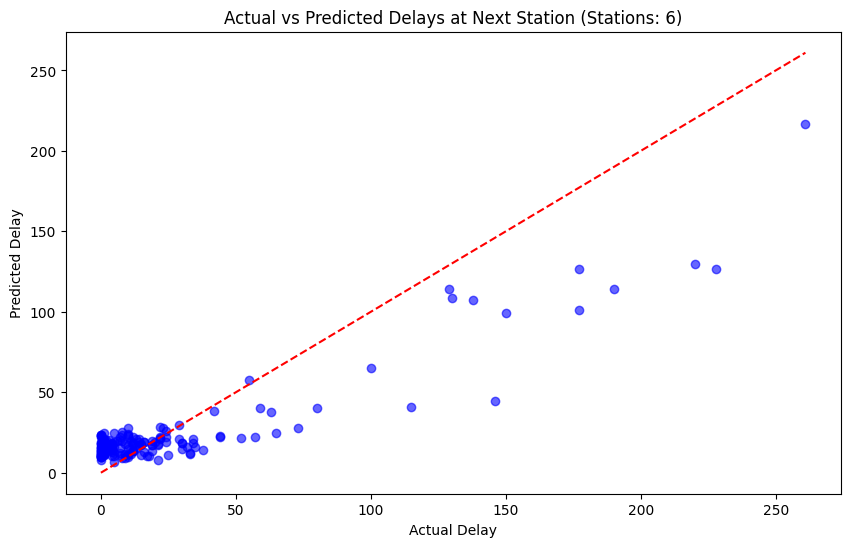


Training and Testing for 7 Stations
Epoch 1/100


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0307 - val_loss: 0.0030
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - val_loss: 0.0027
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - val_loss: 0.0017
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 7.6657e-04
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 5.1661e-04
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 3.8442e-04
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 9.6329e-04
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 4.1883e-04
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 3.6121e-04
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 3.7995e-04
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 4.0380e-04
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 

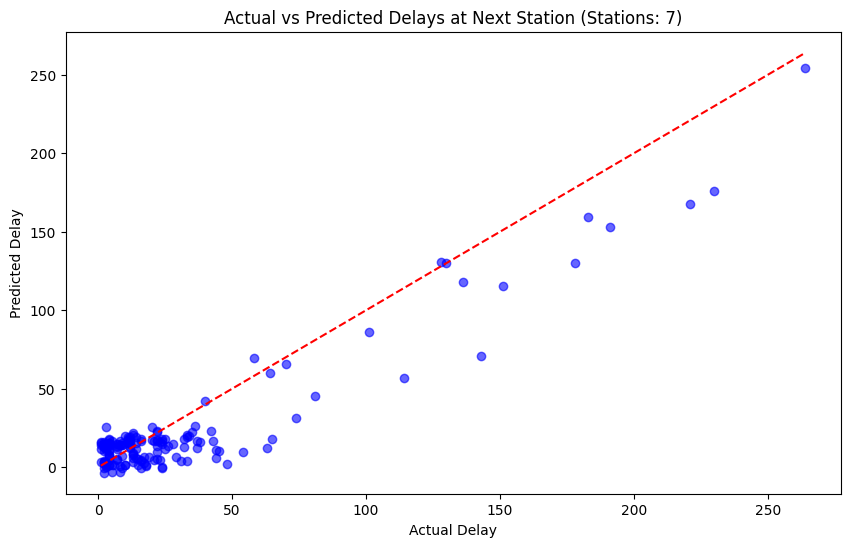


Training and Testing for 8 Stations
Epoch 1/100


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0177 - val_loss: 0.0035
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0015
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 9.4688e-04
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 6.6612e-04
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 9.7976e-04
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 8.5813e-04
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 5.3599e-04
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 6.4089e-04
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

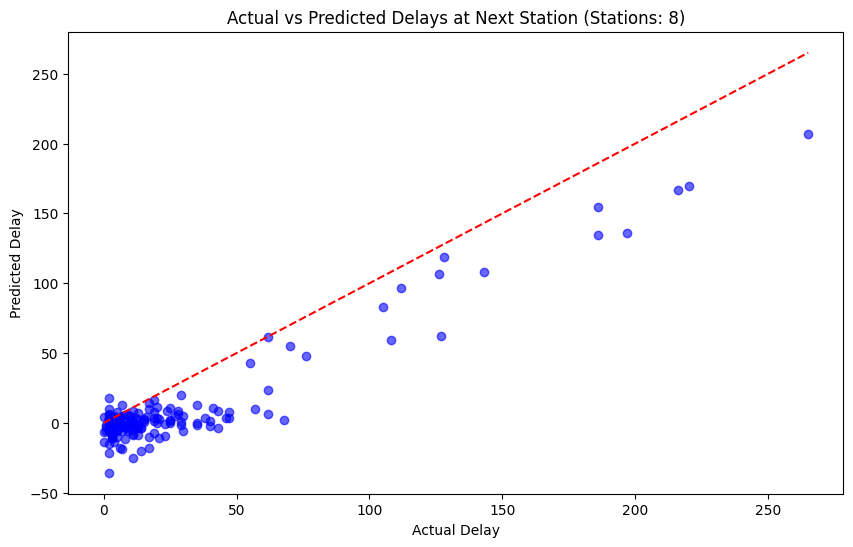


Training and Testing for 9 Stations
Epoch 1/100


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0114 - val_loss: 0.0015
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 7.6430e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 5.5434e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 7.9514e-04
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 5.4723e-04
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 6.2051e-04
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 5.8963e-04
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 5.0391e-04
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 4.8051e-04
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 6.4446e-04
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 5.6162e-04
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━

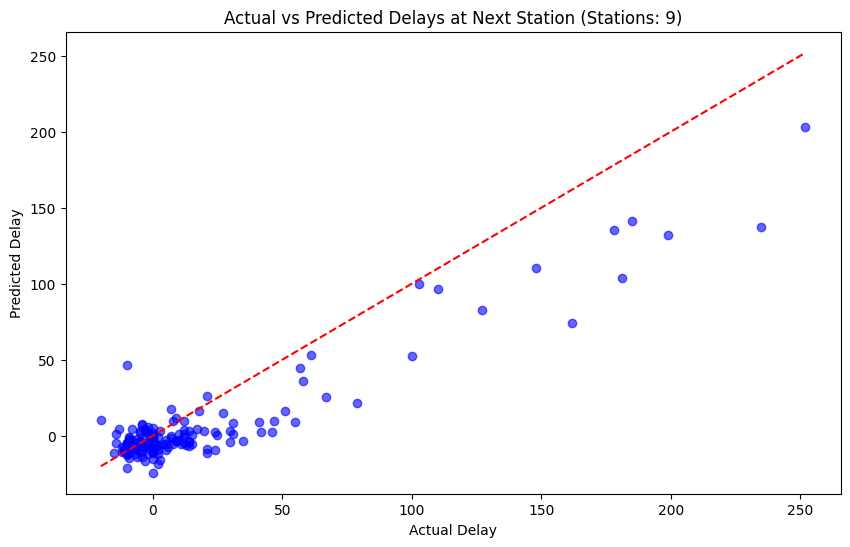

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load and preprocess the dataset
data = pd.read_excel('Train_Data.xlsx')  # Replace with your file name
data = data.dropna()
data = data.drop(columns=['Date'])  # Drop Date column if not needed

# Feature aggregation function
def aggregate_features(data, num_stations):
    """
    Aggregate features for the given number of stations.
    Args:
        data (DataFrame): Input dataset.
        num_stations (int): Number of stations provided for prediction.
    Returns:
        X (ndarray): Aggregated features for the model.
        y (ndarray): Target delays for the next station.
    """
    aggregated_features = []

    # Aggregate features (e.g., average of temperature, distance, wind speed, etc.)
    avg_temperature = np.mean([data[f'Temperature_S{i}'] for i in range(1, num_stations + 1)], axis=0)
    avg_wind_speed = np.mean([data[f'Wind_Speed_S{i}'] for i in range(1, num_stations + 1)], axis=0)
    avg_distance = np.mean([data[f'Distance_travelled_S{i}'] for i in range(1, num_stations + 1)], axis=0)
    avg_weather_code = np.mean([data[f'weather_code_S{i}'] for i in range(1, num_stations + 1)], axis=0)
    avg_previous_delay = np.mean([data[f'S{i}'] for i in range(1, num_stations + 1)], axis=0)

    # Specific features at the next station
    next_weather_code = data[f'weather_code_S{num_stations + 1}']
    next_temperature = data[f'Temperature_S{num_stations + 1}']
    next_wind_speed = data[f'Wind_Speed_S{num_stations + 1}']
    next_distance = data[f'Distance_travelled_S{num_stations + 1}']

    # Combine all aggregated and specific features
    aggregated_features.append(avg_temperature)
    aggregated_features.append(avg_wind_speed)
    aggregated_features.append(avg_distance)
    aggregated_features.append(avg_weather_code)
    aggregated_features.append(avg_previous_delay)
    aggregated_features.append(next_weather_code)
    aggregated_features.append(next_temperature)
    aggregated_features.append(next_wind_speed)
    aggregated_features.append(next_distance)

    X = np.column_stack(aggregated_features)  # Stack features as columns
    y = data[f'S{num_stations + 1}'].values  # Delay at the next station
    return X, y

# Function to train and evaluate the model
def train_and_evaluate(data, num_stations):
    # Aggregate features and target
    X, y = aggregate_features(data, num_stations)

    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Train-Test Split
    train_size = int(0.8 * X_scaled.shape[0])
    X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
    y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

    # Build the Dense model
    model = Sequential([
        Dense(200, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.3),
        Dense(100, activation='relu'),
        Dropout(0.3),
        Dense(1)  # Predicting delay for the next station
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

    # Predictions
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Evaluation
    y_test_actual = scaler_y.inverse_transform(y_test)
    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_actual, y_pred)

    print(f"Number of Stations: {num_stations}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-Squared (R²): {r2}")

    # Plot predictions vs actual using scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_actual, y_pred, color='blue', alpha=0.6)
    plt.xlabel('Actual Delay')
    plt.ylabel('Predicted Delay')
    plt.title(f'Actual vs Predicted Delays at Next Station (Stations: {num_stations})')
    plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--')  # Diagonal line for perfect prediction
    plt.show()

    return model, scaler_X, scaler_y

# Train and evaluate incrementally
for num_stations in range(2, 10):
    print(f"\nTraining and Testing for {num_stations} Stations")
    model, scaler_X, scaler_y = train_and_evaluate(data, num_stations)



Training and Testing for 2 Stations


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Validation Results (Meta-Model):
Mean Squared Error (MSE): 561.6995353192549
Root Mean Squared Error (RMSE): 23.700201166219134
R-Squared (R²): 0.9130598589189372
Test Results (Entire Pipeline):
Mean Squared Error (MSE): 1382.2822258163426
Root Mean Squared Error (RMSE): 37.17905627925946
R-Squared (R²): 0.23816428926390243


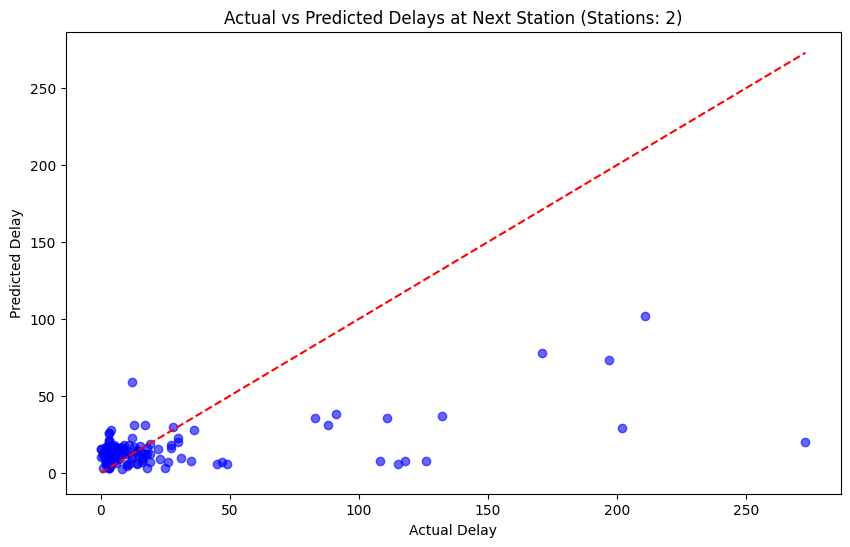


Training and Testing for 3 Stations


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Validation Results (Meta-Model):
Mean Squared Error (MSE): 663.7944218422199
Root Mean Squared Error (RMSE): 25.764208154768117
R-Squared (R²): 0.900715355343365
Test Results (Entire Pipeline):
Mean Squared Error (MSE): 1007.8446595998145
Root Mean Squared Error (RMSE): 31.746569257162488
R-Squared (R²): 0.5093400638456833


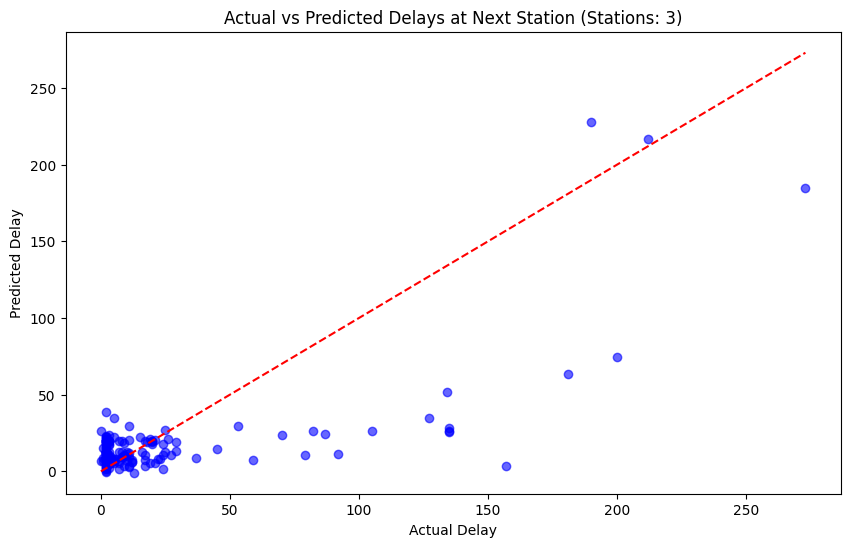


Training and Testing for 4 Stations


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Validation Results (Meta-Model):
Mean Squared Error (MSE): 962.1854388280781
Root Mean Squared Error (RMSE): 31.019114088382313
R-Squared (R²): 0.8575098702646266
Test Results (Entire Pipeline):
Mean Squared Error (MSE): 1569.0228629235576
Root Mean Squared Error (RMSE): 39.61089323561838
R-Squared (R²): 0.24854715934536975


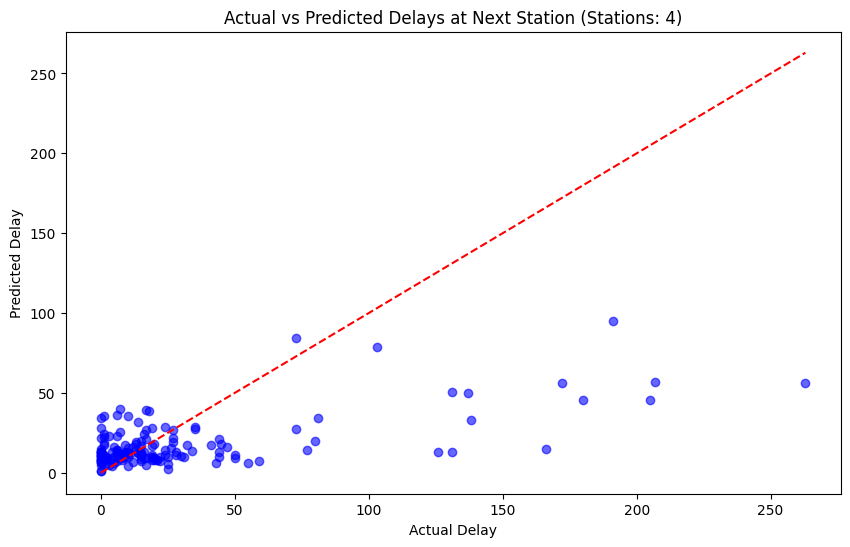


Training and Testing for 5 Stations


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Validation Results (Meta-Model):
Mean Squared Error (MSE): 1044.0810201583145
Root Mean Squared Error (RMSE): 32.312242573958166
R-Squared (R²): 0.8453894296261905
Test Results (Entire Pipeline):
Mean Squared Error (MSE): 2433.26140332718
Root Mean Squared Error (RMSE): 49.3280995308676
R-Squared (R²): -0.0871479837827609


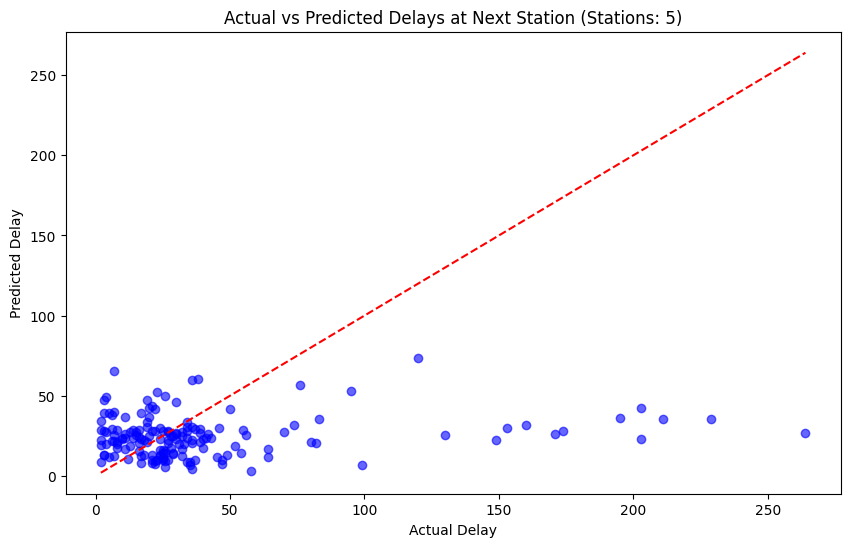


Training and Testing for 6 Stations


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Validation Results (Meta-Model):
Mean Squared Error (MSE): 1443.4061158365703
Root Mean Squared Error (RMSE): 37.99218493106932
R-Squared (R²): 0.7762762304799918
Test Results (Entire Pipeline):
Mean Squared Error (MSE): 1106.5017033449562
Root Mean Squared Error (RMSE): 33.264120360306485
R-Squared (R²): 0.4841852667300319


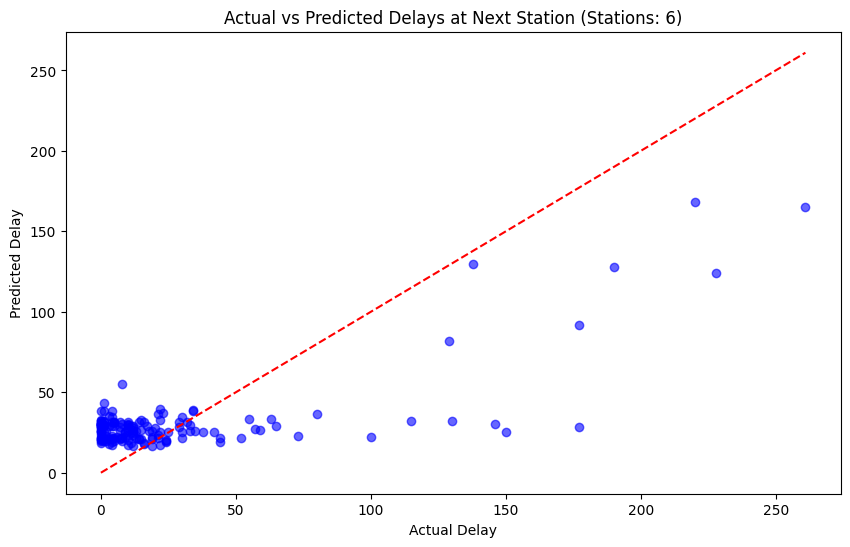


Training and Testing for 7 Stations


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
Validation Results (Meta-Model):
Mean Squared Error (MSE): 1007.6406002814288
Root Mean Squared Error (RMSE): 31.743355214618205
R-Squared (R²): 0.8442781105326852
Test Results (Entire Pipeline):
Mean Squared Error (MSE): 1404.1469962263823
Root Mean Squared Error (RMSE): 37.47194945858011
R-Squared (R²): 0.33048739913577574


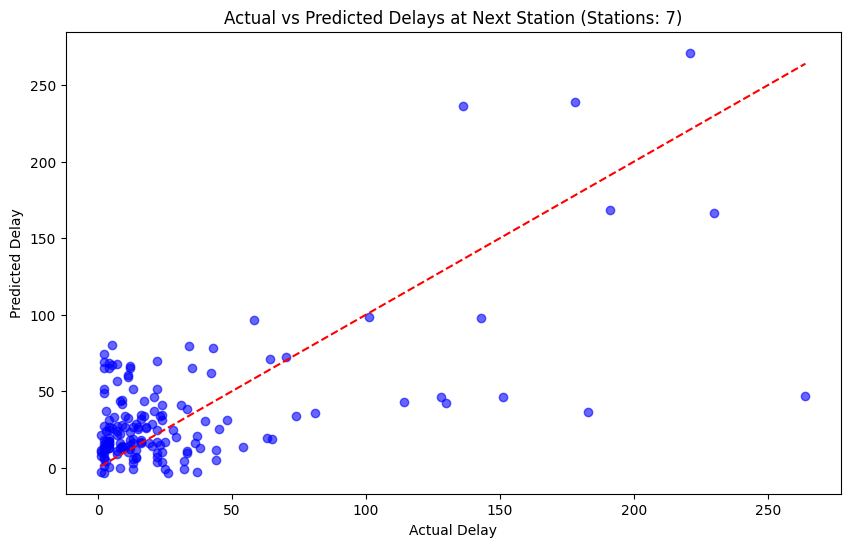


Training and Testing for 8 Stations


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Validation Results (Meta-Model):
Mean Squared Error (MSE): 1082.7521262617233
Root Mean Squared Error (RMSE): 32.90519907646394
R-Squared (R²): 0.8393656185743563
Test Results (Entire Pipeline):
Mean Squared Error (MSE): 1510.8998831145207
Root Mean Squared Error (RMSE): 38.870295639659346
R-Squared (R²): 0.26741594529329216


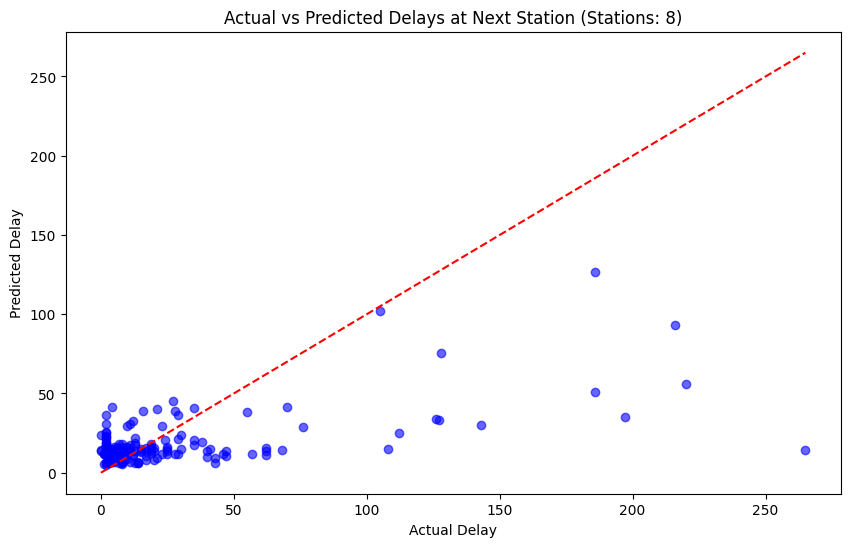


Training and Testing for 9 Stations


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Validation Results (Meta-Model):
Mean Squared Error (MSE): 6979.263978731231
Root Mean Squared Error (RMSE): 83.54198931514159
R-Squared (R²): -0.007229809335698167
Test Results (Entire Pipeline):
Mean Squared Error (MSE): 3202.8266329890935
Root Mean Squared Error (RMSE): 56.59352112202503
R-Squared (R²): -0.44322262095448495


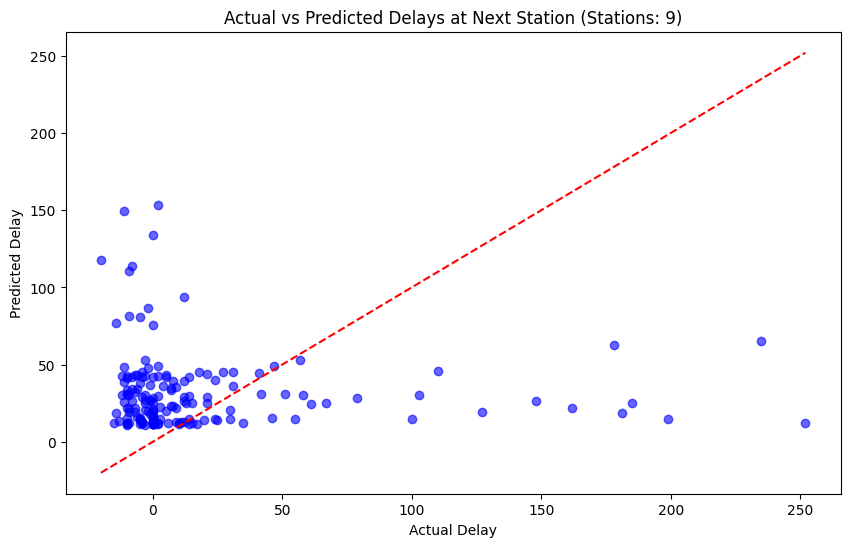

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, SimpleRNN, Dropout
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import matplotlib.pyplot as plt

# Load and preprocess the dataset
data = pd.read_excel('Train_Data.xlsx')  # Replace with your file name
data = data.dropna()
data = data.drop(columns=['Date'])  # Drop Date column if not needed

# Feature aggregation function
def aggregate_features(data, num_stations):
    aggregated_features = []

    # Aggregate features (e.g., average of temperature, distance, wind speed, etc.)
    avg_temperature = np.mean([data[f'Temperature_S{i}'] for i in range(1, num_stations + 1)], axis=0)
    avg_wind_speed = np.mean([data[f'Wind_Speed_S{i}'] for i in range(1, num_stations + 1)], axis=0)
    avg_distance = np.mean([data[f'Distance_travelled_S{i}'] for i in range(1, num_stations + 1)], axis=0)
    avg_weather_code = np.mean([data[f'weather_code_S{i}'] for i in range(1, num_stations + 1)], axis=0)
    avg_previous_delay = np.mean([data[f'S{i}'] for i in range(1, num_stations + 1)], axis=0)

    # Specific features at the next station
    next_weather_code = data[f'weather_code_S{num_stations + 1}']
    next_temperature = data[f'Temperature_S{num_stations + 1}']
    next_wind_speed = data[f'Wind_Speed_S{num_stations + 1}']
    next_distance = data[f'Distance_travelled_S{num_stations + 1}']

    # Combine all aggregated and specific features
    aggregated_features.append(avg_temperature)
    aggregated_features.append(avg_wind_speed)
    aggregated_features.append(avg_distance)
    aggregated_features.append(avg_weather_code)
    aggregated_features.append(avg_previous_delay)
    aggregated_features.append(next_weather_code)
    aggregated_features.append(next_temperature)
    aggregated_features.append(next_wind_speed)
    aggregated_features.append(next_distance)

    X = np.column_stack(aggregated_features)  # Stack features as columns
    y = data[f'S{num_stations + 1}'].values  # Delay at the next station
    return X, y

# Define model functions
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(50, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='relu', return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(50, activation='relu')),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        SimpleRNN(50, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train and evaluate models
def train_meta_model(data, num_stations):
    # Aggregate features
    X, y = aggregate_features(data, num_stations)

    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Initial Train-Test Split (80:20)
    train_size = int(0.8 * X_scaled.shape[0])
    X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
    y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

    input_shape = (X_train.shape[1], 1)

    # Reshape for LSTM, BiLSTM, RNN
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Train individual models and gather predictions
    models_output_train, models_output_meta = [], []

    # LSTM
    lstm_model = build_lstm_model(input_shape)
    lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=16, verbose=0)
    models_output_train.append(lstm_model.predict(X_train_reshaped))
    models_output_meta.append(lstm_model.predict(X_test_reshaped))

    # BiLSTM
    bilstm_model = build_bilstm_model(input_shape)
    bilstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=16, verbose=0)
    models_output_train.append(bilstm_model.predict(X_train_reshaped))
    models_output_meta.append(bilstm_model.predict(X_test_reshaped))

    # RNN
    rnn_model = build_rnn_model(input_shape)
    rnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=16, verbose=0)
    models_output_train.append(rnn_model.predict(X_train_reshaped))
    models_output_meta.append(rnn_model.predict(X_test_reshaped))

    # BiRNN
    birnn_model = Sequential([
        Bidirectional(SimpleRNN(50, activation='relu', return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(SimpleRNN(50, activation='relu')),
        Dropout(0.3),
        Dense(1)
    ])
    birnn_model.compile(optimizer='adam', loss='mean_squared_error')
    birnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=16, verbose=0)
    models_output_train.append(birnn_model.predict(X_train_reshaped))
    models_output_meta.append(birnn_model.predict(X_test_reshaped))

    # ARIMA
    arima_predictions_train, arima_predictions_meta = [], []
    for i in range(X_train.shape[0]):
        model = ARIMA(y_train.flatten(), order=(1, 1, 1))
        fitted = model.fit()
        pred = fitted.forecast(steps=1)[0]
        arima_predictions_train.append(pred)

    for i in range(X_test.shape[0]):
        model = ARIMA(y_train.flatten(), order=(1, 1, 1))
        fitted = model.fit()
        pred = fitted.forecast(steps=1)[0]
        arima_predictions_meta.append(pred)

    models_output_train.append(np.array(arima_predictions_train).reshape(-1, 1))
    models_output_meta.append(np.array(arima_predictions_meta).reshape(-1, 1))

    # Combine outputs
    meta_features_train = np.hstack(models_output_train)
    meta_features_meta = np.hstack(models_output_meta)

    # Split meta-features into 80:20 for training and testing XGBoost
    meta_train_size = int(0.8 * meta_features_train.shape[0])
    X_meta_train, X_meta_val = meta_features_train[:meta_train_size], meta_features_train[meta_train_size:]
    y_meta_train, y_meta_val = y_train[:meta_train_size], y_train[meta_train_size:]

    # Train XGBoost meta-model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    xgb_model.fit(X_meta_train, y_meta_train)

    # Evaluate meta-model on the validation set
    y_meta_val_pred = xgb_model.predict(X_meta_val)
    y_meta_val_actual = scaler_y.inverse_transform(y_meta_val)
    y_meta_val_pred_actual = scaler_y.inverse_transform(y_meta_val_pred.reshape(-1, 1))

    mse_val = mean_squared_error(y_meta_val_actual, y_meta_val_pred_actual)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(y_meta_val_actual, y_meta_val_pred_actual)

    print(f"Validation Results (Meta-Model):")
    print(f"Mean Squared Error (MSE): {mse_val}")
    print(f"Root Mean Squared Error (RMSE): {rmse_val}")
    print(f"R-Squared (R²): {r2_val}")

    # Evaluate the entire pipeline on the initial 20% test set
    meta_features_test = np.hstack(models_output_meta)
    y_test_pred = xgb_model.predict(meta_features_test)
    y_test_actual = scaler_y.inverse_transform(y_test)
    y_test_pred_actual = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))

    mse_test = mean_squared_error(y_test_actual, y_test_pred_actual)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test_actual, y_test_pred_actual)

    print(f"Test Results (Entire Pipeline):")
    print(f"Mean Squared Error (MSE): {mse_test}")
    print(f"Root Mean Squared Error (RMSE): {rmse_test}")
    print(f"R-Squared (R²): {r2_test}")

    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_actual, y_test_pred_actual, color='blue', alpha=0.6)
    plt.xlabel('Actual Delay')
    plt.ylabel('Predicted Delay')
    plt.title(f'Actual vs Predicted Delays at Next Station (Stations: {num_stations})')
    plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--')
    plt.show()

# Train and evaluate incrementally
for num_stations in range(2, 10):
    print(f"\nTraining and Testing for {num_stations} Stations")
    train_meta_model(data, num_stations)
